# Importing Dependencies

In [1]:
# Importing Dependencies
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow.keras import layers, models
import tensorflow_datasets as tfds
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler,EarlyStopping
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

2025-05-06 20:12:14.550641: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-06 20:12:14.574006: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746551534.599140   33192 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746551534.605524   33192 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746551534.623265   33192 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
    # Checking For GPU 
    print('Using:')
    print('\t\u2022 TensorFlow version:', tf.__version__)
    print('\t\u2022 Running on GPU' if tf.config.list_physical_devices('GPU') else '\t\u2022 GPU device not found. Running on CPU')
    physical_devices = tf.config.list_physical_devices('GPU')
    for device in physical_devices:
        tf.config.experimental.set_memory_growth(device, True)

Using:
	• TensorFlow version: 2.19.0
	• Running on GPU


# Data Collection

 

In [3]:
def load_data():
    
    """
    Loading Cifar - Classes Dataset

    """
    ds, info = tfds.load('cifar10',split = ['train[:80%]','train[80%:]','test'],as_supervised=True,with_info=True)
    train_set , val_set,test_set = ds
    print(info)
    return train_set,val_set,test_set,info

# Data Exploration

In [4]:

def data_exploration(info):
    """
    Exploring the dataset with details such as features , dataset size , splits , etc..

    """
    # Extracting shape , number of classes and labels
    image_shape = info.features['image'].shape
    num_classes = info.features['label'].num_classes
    labels = info.features['label'].names

    # Train size before splitting into validation and training set
    train_val_size = info.splits['train'].num_examples

    # Defining sizes for each set
    test_size = info.splits['test'].num_examples
    train_size = train_val_size * 0.8
    val_size = train_val_size *0.2
    # Whole Size of Dataset
    dataset_size =  train_size+val_size +test_size

    # Printing
    print("train size",train_size)
    print("validation size",val_size)
    print("test size",test_size)
    print("dataset total size : ",dataset_size)

    print("image shape : ",image_shape)
    print("dataset num of classes : ",num_classes)
    print("dataset labels : ", labels) 
    return image_shape,num_classes,labels



In [5]:
# Mapping numeric labels into catagorical
def mapping_into_catagorical(num_classes,labels):
  """
  Function for mapping numerical values into catagorical & readable ones

  """
  labels_catogorical = dict()
  for i in range(num_classes):
    labels_catogorical[i] = labels[i]
  return labels_catogorical

# Exploring few samples

def samples_visualization(samples,labels_catogorical):
  # Exploring few samples
  count = 1
  for img , label in samples:

    # Printing Sample Info
    print(f" Image # {count} shape  : ({img.shape}) ")
    
    

    # Plotting Sample
    img = img.numpy().squeeze()
    label = label.numpy()
    plt.imshow(img)
    plt.title(labels_catogorical[label])
    plt.show()
    count+=1


# Data Augmentation

In [6]:
def augment_image(image, label):
    """
    Preprocessing images with augmentation.
    """
    
    image = tf.image.random_flip_left_right(image) 
    image = tf.image.random_flip_up_down(image) 
    image = tf.image.random_brightness(image, max_delta=0.2) 
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)  
     
    return image, label

# Creating Piepline


In [7]:
# Preprocessing Images with fixed size & one hot encoding
def process_image_and_encode(label, img, img_size=32, num_classes=10,with_augmentation=False):
    """
    Preprocessing  in addition to one-hot-encoding at one sample level
    """
    # Normalization
    img = tf.cast(img, tf.float32)
    img = tf.image.resize(img, (img_size, img_size))    
    img /= 255.0

    # Augmentation Flow
    if with_augmentation:
        img,label= augment_image(img,label)
        
        

    # one hot encoding
    label = tf.one_hot(label, depth=num_classes)
    return img, label

    

def construct_pipeline(train_set,val_set,test_set,batch_size = 64,with_augmentation=False):

    """
    Constructuring pipeline stages for creating dataset batches
    
    """

    train_examples_size =len(train_set)

    # Constructing Batches for each set
    # Prefethcing stands for optimization purposes , for a faster loading in memory to next batch when training on current batch
    train_batches =train_set.shuffle(train_examples_size//4).map(lambda image , label : process_image_and_encode(label,image,32,10,True)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    val_batches =  val_set.map(lambda image , label : process_image_and_encode(label,image,32,10,False)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    test_batches = test_set.map(lambda image , label : process_image_and_encode(label,image,32,10,False)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return train_batches,val_batches,test_batches 

# Model Building

In [8]:
def build_cnn_model(input_shape=(32,32, 3)):
    """
    Build a CNN model for CIFAR-10 classification.
    """
    model = models.Sequential([
        # Convolutional layers
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        
        # Fully connected layers
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(10, activation='softmax')  # Output layer for 10 classes
    ])
    
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Model with Modificaitons Building

In [9]:
from tensorflow.keras import models, layers
# Commented Model with val_accuracy about %64
# def build_cnn_model_with_modifications(input_shape=(32, 32, 3)):
#     model = models.Sequential([
#         # Conv Block #1
#         layers.Conv2D(32, (5, 5), activation='relu', padding="same", input_shape=input_shape),
#         layers.BatchNormalization(),
#         layers.Dropout(0.2),
#         layers.MaxPooling2D((2, 2)),

#         # Conv Block #2
#         layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
#         layers.BatchNormalization(),
#         layers.Dropout(0.3),
#         layers.MaxPooling2D((2, 2)),

#         # Conv Block #3
#         layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
#         layers.BatchNormalization(),
#         layers.Dropout(0.3),
#         layers.MaxPooling2D((2, 2)),

#         # Conv Block #4
#         layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
#         layers.BatchNormalization(),
#         layers.Dropout(0.4),
#         layers.GlobalAveragePooling2D(),  
        
#         # Fully connected layers
#         layers.Dense(256, activation='relu'),
#         layers.Dropout(0.5),
#         layers.Dense(128, activation='relu'),
#         layers.Dropout(0.5),
#         layers.Dense(10, activation='softmax')
#     ])
    
#     model.compile(optimizer='adam',
#                   loss='categorical_crossentropy',
#                   metrics=['accuracy'])
#     return model

def build_cnn_model_with_modifications(input_shape=(32,32,3)):
    """
    Building another model, with 2 Conv Layers => pooling technique 
        """

    model = models.Sequential([

            # Conv Block #1
    layers.Conv2D(64, (4,4), input_shape=input_shape, padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),

    layers.Conv2D(64, (4,4), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),

    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Dropout(0.2),

    # Conv Block #2
    layers.Conv2D(128, (4,4), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),

    layers.Conv2D(128, (4,4), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),

    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Dropout(0.25),

    # Conv Block #3
    layers.Conv2D(128, (4,4), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),

    layers.Conv2D(128, (4,4), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),

    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Dropout(0.3),           

    # 128 * (4*4*128)
    # Dense Layer #4
    layers.Flatten(),
    layers.Dense(256),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.35),

    layers.Dense(10, activation='softmax'),
    ])

    model.compile(optimizer='adam',loss='categorical_crossentropy',metrics = ['accuracy'])
    return model


# Model Training 

In [10]:
# Callbacks Definition
def callbacks():
    """Define callbacks for training the model"""
# Define a learning rate schedule
    def lr_schedule(epoch):
        """ 
        Scheduling Learning rate to be reduced every x times epochs

        """
        initial_lr = 0.001
        decay_factor = 0.1
        decay_epochs = 5
        lr = initial_lr * (decay_factor ** (epoch // decay_epochs))
        return lr

    # Create a learning rate scheduler callback
    lr_scheduler = LearningRateScheduler(lr_schedule)

    early_stopping = EarlyStopping(
        monitor='val_loss',  # Monitor validation loss
        patience=10,          # Stop after 5 epochs without improvement
        restore_best_weights=True  # Restore the best model weights
    )
    return [early_stopping]#[lr_scheduler,early_stopping]

In [11]:
# Model Training
def train_model(model,train_batches, val_batches , epochs , callbacks  ):
    
    history = model.fit(train_batches,validation_data = val_batches , epochs = epochs , callbacks=callbacks)
    return history

# Save Model


In [12]:
def save_model(model, path):
 
    """
    Saving the model as a file. 
    """
    model.save(path)
    print("Model {} saved at {}".format(model.name,path))

def load_model(path):
    """
    Loading an existing model 
    """
    model = models.load_model(path)
    print(f"Model loaded from {path}")
    return model
    


# Model Evaluation



In [13]:
def model_evaluation(model,test_batches):
    test_loss , test_accuracy = model.evaluate(test_batches)
    print(f"Test accuracy: {test_accuracy:.4f}")
    
    return test_loss,test_accuracy



# Plot Training Results

In [14]:
def plot_training_results(history):
    """
    Plot training and validation accuracy/loss curves.
    """
    # Plot accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Visulization Filters , Feature Maps and Confusion Matrix

In [15]:
# Confusion Matrix function
def plot_confusion_matrix(model, test_batches,labels_catogorical):
    """
    Plot a confusion matrix for the model's predictions.
    """
    predicted_labels = [] 
    true_labels = []
    for img , label in test_batches:
        
        predictions = model.predict(img)
        predicted_labels.extend(np.argmax(predictions, axis=1))
        true_labels.extend(np.argmax(label, axis=1))
    
    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[labels_catogorical[x] for x in range(10)], yticklabels=[labels_catogorical[x] for x in range(10)])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

def visualize_feature_maps(model, test_batches, layer_index=0, num_images=1):
    """
    Visualize the feature maps of a specific convolutional layer for a given number of images
    from a TensorFlow dataset.
    """
    # Create a model that outputs the feature maps of the specified layer
    feature_map_model = tf.keras.models.Model(inputs=model.inputs, 
                                               outputs=model.layers[layer_index].output)
    
    # Take a subset of the test dataset and loop through the required number of images
    for idx, (images, _) in enumerate(test_batches.take(num_images)):
        # Expand dimensions for a single input image (if not already batched)
        input_image = tf.expand_dims(images[0], axis=0) if len(images.shape) == 3 else images[0:1]
        
        # Get the feature maps for the input image
        feature_maps = feature_map_model.predict(input_image)
        
        # Plot the feature maps
        plt.figure(figsize=(15, 15))
        num_filters = feature_maps.shape[-1]  # Number of feature map filters
        grid_size = int(np.ceil(np.sqrt(num_filters)))  # Define grid size for subplots

        for j in range(num_filters):
            plt.subplot(grid_size, grid_size, j + 1)
            plt.imshow(feature_maps[0, :, :, j], cmap='viridis')
            plt.axis('off')
        
        # Add a title for clarity
        plt.suptitle(f'Feature Maps for Layer {layer_index} (Image {idx + 1})', fontsize=16)
        plt.show()

        # Stop after processing the required number of images
        if idx + 1 >= num_images:
            break


# Visulaizing Filters Function
def visualize_filters(model):
    """
    Visualize the filters (kernels) of the first convolutional layer.
    """
    first_layer = model.layers[0]
    filters, biases = first_layer.get_weights()
    
    plt.figure(figsize=(8, 8))
    for i in range(min(16, filters.shape[3])):  # Show first 16 filters
        plt.subplot(4, 4, i+1)
        plt.imshow(filters[:, :, 0, i], cmap='gray')
        plt.axis('off')
    plt.suptitle('Filters of the First Convolutional Layer')
    plt.show()





I0000 00:00:1746551542.220443   33192 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3586 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


tfds.core.DatasetInfo(
    name='cifar10',
    full_name='cifar10/3.0.2',
    description="""
    The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.
    """,
    homepage='https://www.cs.toronto.edu/~kriz/cifar.html',
    data_dir='/home/ahmad/tensorflow_datasets/cifar10/3.0.2',
    file_format=tfrecord,
    download_size=162.17 MiB,
    dataset_size=132.40 MiB,
    features=FeaturesDict({
        'id': Text(shape=(), dtype=string),
        'image': Image(shape=(32, 32, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    nondeterministic_order=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=50000, num_shards=1>,
    },
    citation="""@TECHREPORT{Krizhevsky09learningmultiple,
        author = {A

2025-05-06 20:12:22.588809: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:387] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608


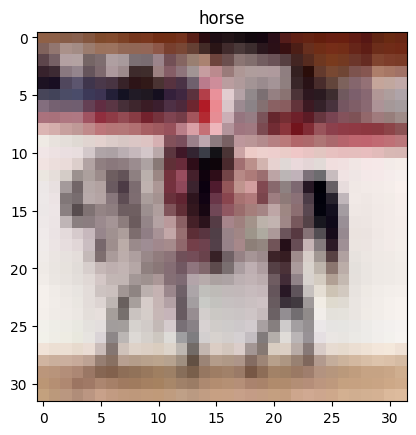

 Image # 2 shape  : ((32, 32, 3)) 


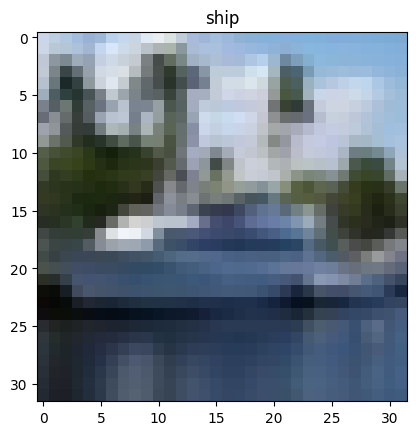

 Image # 3 shape  : ((32, 32, 3)) 


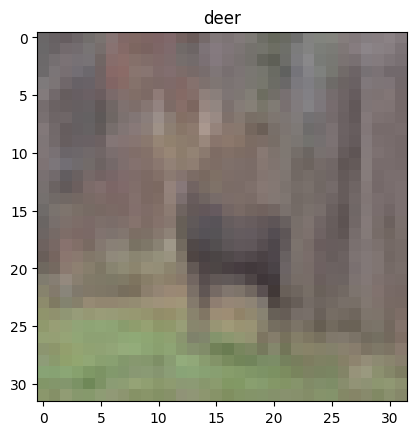

 Image # 4 shape  : ((32, 32, 3)) 


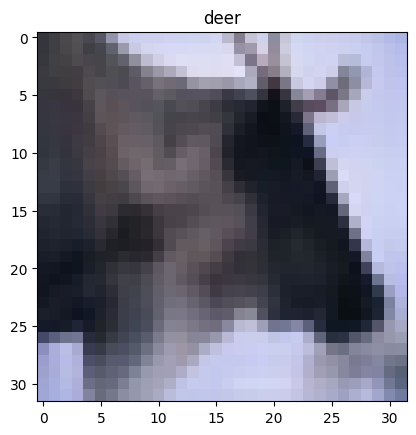

 Image # 5 shape  : ((32, 32, 3)) 


2025-05-06 20:12:23.059561: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


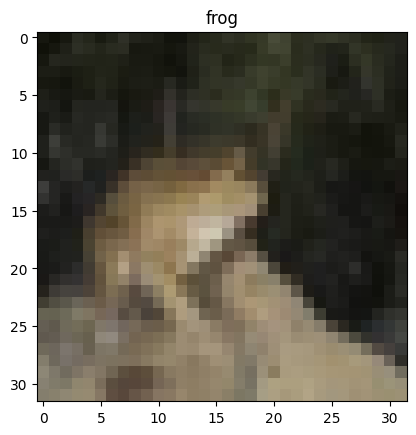

2025-05-06 20:12:23.168944: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 1/50


I0000 00:00:1746551548.773285   33281 service.cc:152] XLA service 0x7f58f402e7b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746551548.773337   33281 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2025-05-06 20:12:28.949022: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1746551549.868047   33281 cuda_dnn.cc:529] Loaded cuDNN version 90600
I0000 00:00:1746551560.813994   33281 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


625/625 ━━━━━━━━━━━━━━━━━━━━ 34s 27ms/step - accuracy: 0.2881 - loss: 2.0059 - val_accuracy: 0.5178 - val_loss: 1.3272
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - accuracy: 0.5320 - loss: 1.2932 - val_accuracy: 0.5564 - val_loss: 1.2155
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.6273 - loss: 1.0458 - val_accuracy: 0.5812 - val_loss: 1.1855
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - accuracy: 0.6670 - loss: 0.9379 - val_accuracy: 0.6723 - val_loss: 0.9167
Epoch 5/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.6973 - loss: 0.8591 - val_accuracy: 0.7096 - val_loss: 0.8420
Epoch 6/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - accuracy: 0.7168 - loss: 0.8012 - val_accuracy: 0.6719 - val_loss: 0.9696
Epoch 7/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - accuracy: 0.7370 - loss: 0.7451 - val_accuracy: 0.7590 - val_loss: 0.6861
Epoch 8/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - accuracy: 0.7550 - loss: 0.6946 - val_accurac

Model sequential saved at modified_model.h5


Model loaded from modified_model.h5
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.8490 - loss: 0.4415
Test accuracy: 0.8492


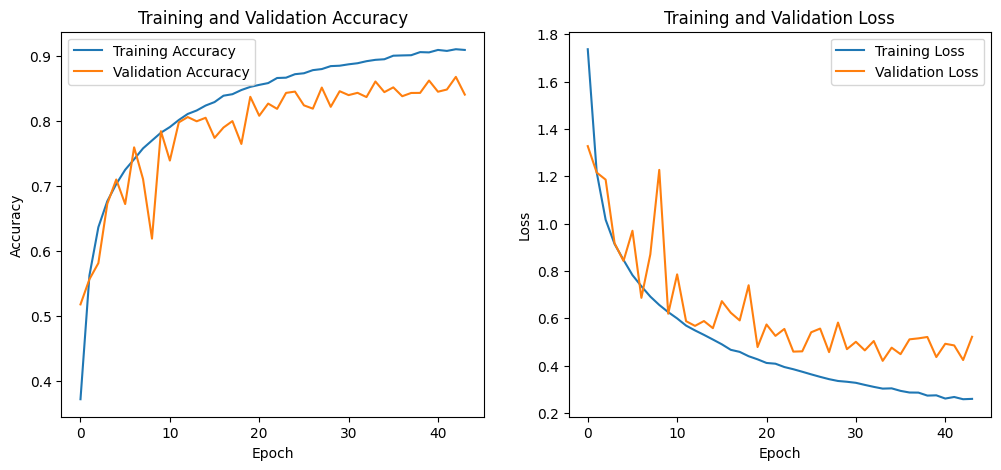

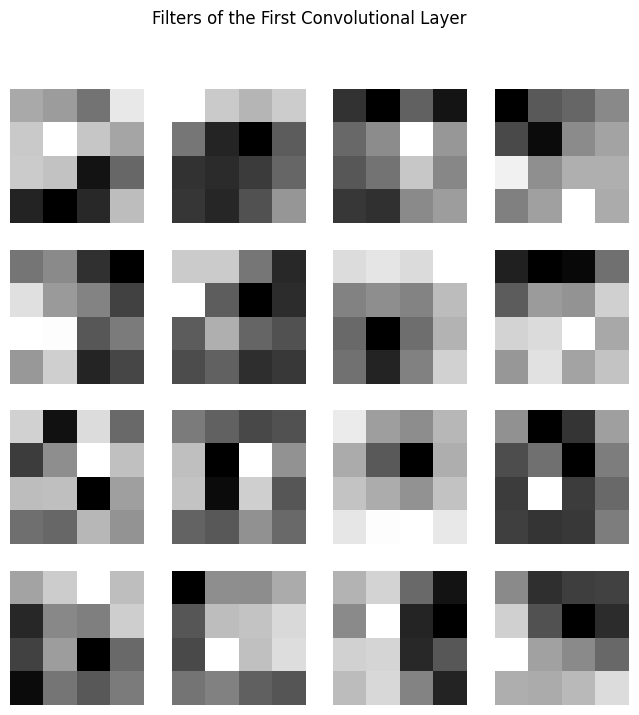

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
2/2 ━━━━━━━━

2025-05-06 20:25:05.657519: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


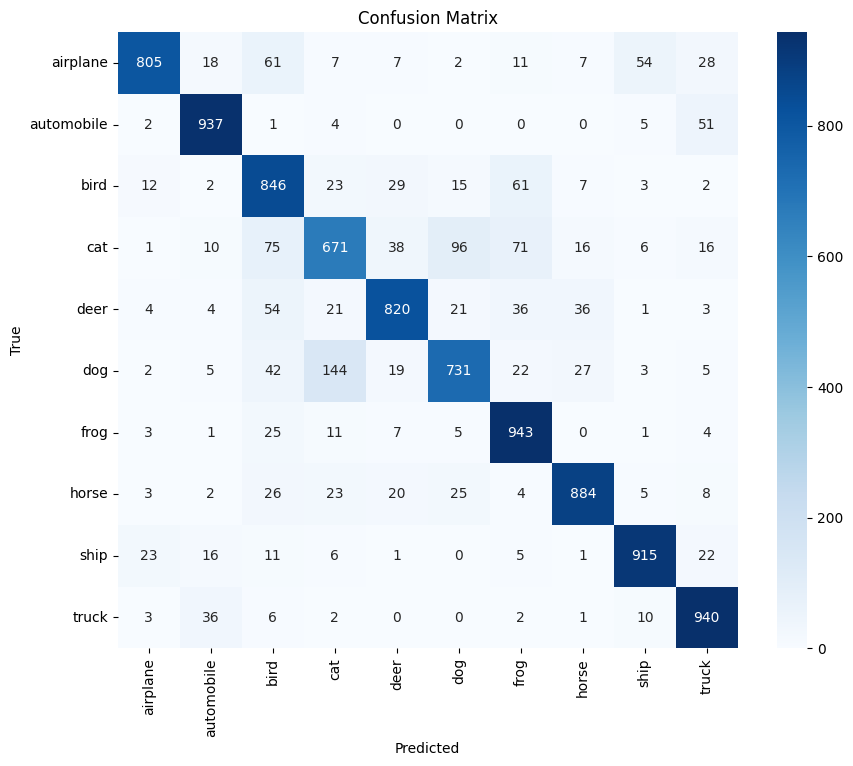

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 502ms/step


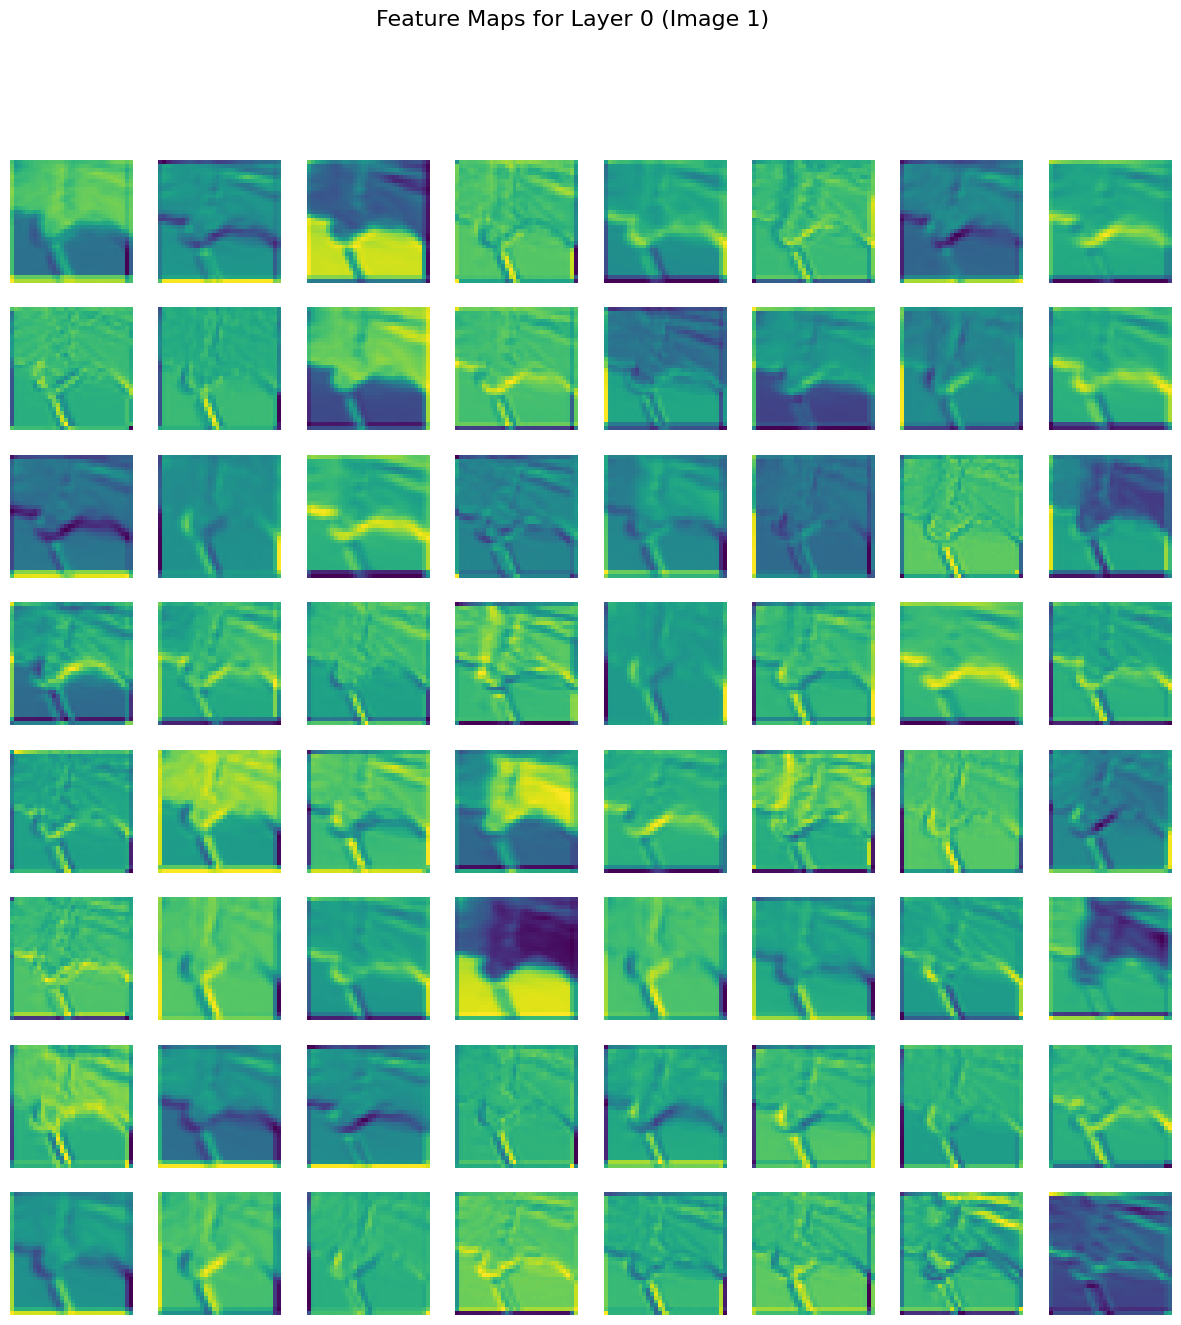

In [16]:
def main():
    # Loading Datasets
    (train_set,val_set,test_set,info) = load_data()
    
    # Exploring the dataset
    image_shape,num_classes,labels = data_exploration(info)
    labels_catogorical = mapping_into_catagorical(num_classes,labels)
    
    # Few Samples Visualization
    samples_visualization(samples=train_set.take(5),labels_catogorical=labels_catogorical)

    # Constructing Model Pipeline
    (train_batches,val_batches,test_batches)= construct_pipeline(train_set,val_set,test_set , batch_size=64,with_augmentation=True)
    
    # Building & Compiling the model
    model  =build_cnn_model_with_modifications(input_shape=(32,32,3))
    
    # Training the model 
    history = train_model(model = model ,train_batches=train_batches,val_batches=val_batches,epochs=50,callbacks=callbacks())
    save_model(model,"modified_model.h5")
    model = load_model('modified_model.h5')
    model_evaluation(model=model,test_batches=test_batches)
    plot_training_results(history)
    visualize_filters(model)
    plot_confusion_matrix(model,test_batches,labels_catogorical)
    visualize_feature_maps(model,test_batches)
    
if __name__ == "__main__":
    main()

